# 1. Data Preparation

## Load packages

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import sklearn.model_selection
import gensim
from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2022)
import nltk
stemmer = SnowballStemmer("english")
from gensim import corpora, models

## Read data

##### You can use data set you have. 

In [2]:
from collections import defaultdict
from pathlib import Path

my_dir_path = "/Users/zh15n/OneDrive - University of Tennessee/PhD/Social Media/1_Abstracts"

results = defaultdict(list)
for file in Path(my_dir_path).iterdir():
    with open(file, "r",encoding='latin-1') as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
documents = pd.DataFrame(results)

In [3]:
documents.head(5)

,file_name,text
0,1101.0012.txt,Analyticity of extremisers to the Airy Stricha...
1,1101.0013.txt,A Harnack inequality for fractional Laplace eq...
2,1101.0015.txt,Cluster structures on simple complex Lie group...
3,1101.0017.txt,Compactness of $\Box_b$ in a CR manifold;;; Tr...
4,1101.0023.txt,"The Multiplication on BP;;; Maria Basterra,, ..."


In [4]:
print(len(documents))

976


### Clean the texts using regular expressions (Lowercase the words, remove punctuation, etc.).


In [5]:
def clean_data(file):
    file = file.lower()
    file = re.sub(r'http\S+', "", file)         # Remove https
    file = re.sub("\n", "", file)               # Remove new lines
    file = re.sub("&amp", "", file)             # Remove html special character
    file = re.sub("<a href", "", file)          # Remove html special character
    file = re.sub(">", "", file)                # Remove html special character
    file = re.sub("#", "", file)                # Remove #
    file = re.sub(r"[^\w\s]", "", file)         # Remove punctuations
    file = re.sub(r"\b[a-zA-Z]\b", "", file)    # Remove one-letter words
    file = re.sub(r' +', ' ', file)             # Remove multiple white spaces
    return file

documents['text'] = documents['text'].apply(lambda x: clean_data(x))

### Remove the Stopwords
 - a, the, of,...

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
documents['text'] = documents['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Lemmatizing and Stemming

 - Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

 - Words are stemmed — words are reduced to their root form. 
 
   -- E.g., the boy's cars are different colors $\Rightarrow$ the boy car be differ color

In [7]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def stem_lemmatize_text(text):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(text)]

documents['text'] = documents['text'].apply(lambda x: ' '.join(stem_lemmatize_text(x)))

In [8]:
documents.head(5)

,file_name,text
0,1101.0012.txt,analyt extremis airi strichartz inequ dirk hun...
1,1101.0013.txt,harnack inequ fraction laplac equat lower orde...
2,1101.0015.txt,cluster structur simpl complex lie group belav...
3,1101.0017.txt,compact box_b cr manifold tran vu khanh findma...
4,1101.0023.txt,multipl bp maria basterra findmath1aumandell_m...


# 2. Explanatory analysis - WordCloud

In [9]:
# join the texts
texts = " ".join(t for t in documents["text"])

In [10]:
from wordcloud import WordCloud, ImageColorGenerator
wordcloud = WordCloud(width = 1500, height = 800, background_color="white",collocations = False).generate(texts)


Bad key text.latex.unicode in file C:\Users\zh15n\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\zh15n\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\zh15n\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/m

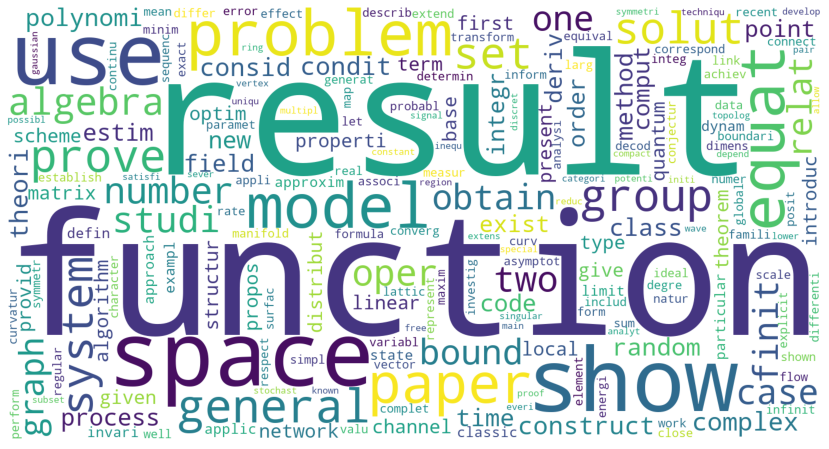

In [11]:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 3. Run LDA Topic Model Using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

### Tokenization: Split each text into sentences and the sentences into words. 

In [12]:
def preprocess(text): # tokenization
    result = []
    for token in gensim.utils.simple_preprocess(text):
            result.append(token)
    return [x.encode('utf-8') for x in result]
    #return result

## Bag of Words on the Data set

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [13]:
processed_docs = documents['text'].map(preprocess)
id2word = gensim.corpora.Dictionary(processed_docs)
print(id2word)

#Here is the first 5 words in the data dictionary: id + word
count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 4:
        break

Dictionary(11557 unique tokens: ['airi', 'all', 'analyt', 'argument', 'aushao_s']...)
0 airi
1 all
2 analyt
3 argument
4 aushao_s


## Filter out tokens that appear in

less than 3 documents (absolute number)
    
more than 0.5 documents (fraction of total corpus size, not absolute number)

After the above two steps, keep the top frequent 3000 tokens (optinal)


In [14]:
id2word.filter_extremes(no_below=3, no_above=0.5, keep_n=3000)

## Word count

For each document we create a dictionary reporting how many words and how many times those words appear. 

Save this to ‘bow_corpus’, then check our selected document earlier.

In [15]:
bow_corpus = [id2word.doc2bow(doc) for doc in processed_docs]
#bow_corpus[666]

An example doc

In [16]:
bow_doc_666 = bow_corpus[666]

for i in range(len(bow_doc_666)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_666[i][0], 
                                               id2word[bow_doc_666[i][0]], 
bow_doc_666[i][1]))

Word 28 ("space") appears 1 time.
Word 43 ("term") appears 2 time.
Word 44 ("via") appears 1 time.
Word 50 ("classif") appears 1 time.
Word 65 ("relat") appears 1 time.
Word 69 ("structur") appears 1 time.
Word 115 ("result") appears 1 time.
Word 131 ("spectrum") appears 2 time.
Word 155 ("set") appears 1 time.
Word 180 ("provid") appears 1 time.
Word 188 ("develop") appears 2 time.
Word 194 ("notion") appears 1 time.
Word 208 ("equival") appears 1 time.
Word 310 ("applic") appears 1 time.
Word 344 ("thus") appears 1 time.
Word 376 ("topolog") appears 1 time.
Word 418 ("along") appears 1 time.
Word 501 ("make") appears 1 time.
Word 606 ("upon") appears 1 time.
Word 631 ("improv") appears 1 time.
Word 693 ("model") appears 3 time.
Word 695 ("pair") appears 1 time.
Word 773 ("replac") appears 1 time.
Word 792 ("pet") appears 1 time.
Word 915 ("calculus") appears 3 time.
Word 1055 ("categori") appears 3 time.
Word 1140 ("functor") appears 2 time.
Word 1166 ("role") appears 1 time.
Word 13

In [17]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2)

In [18]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"space" + 0.009*"show" + 0.009*"network" + 0.008*"result" + 0.008*"system" + 0.007*"also" + 0.007*"matrix" + 0.006*"random" + 0.006*"model" + 0.006*"point"
Topic: 1 
Words: 0.011*"function" + 0.009*"bound" + 0.008*"oper" + 0.008*"equat" + 0.008*"result" + 0.007*"prove" + 0.007*"problem" + 0.006*"use" + 0.006*"general" + 0.006*"paper"
Topic: 2 
Words: 0.011*"function" + 0.010*"model" + 0.008*"problem" + 0.007*"result" + 0.007*"number" + 0.007*"use" + 0.007*"polynomi" + 0.006*"graph" + 0.006*"studi" + 0.006*"show"
Topic: 3 
Words: 0.009*"algebra" + 0.009*"field" + 0.009*"graph" + 0.007*"theori" + 0.007*"model" + 0.007*"space" + 0.007*"relat" + 0.006*"represent" + 0.006*"group" + 0.006*"show"
Topic: 4 
Words: 0.015*"group" + 0.010*"algebra" + 0.009*"result" + 0.008*"general" + 0.007*"function" + 0.007*"paper" + 0.007*"show" + 0.006*"prove" + 0.006*"condit" + 0.006*"use"
Topic: 5 
Words: 0.013*"equat" + 0.010*"solut" + 0.008*"problem" + 0.008*"system" + 0.008*"fuzzi"

In [19]:
print(lda_model[bow_corpus[666]]) # Document 666 is ___% about topic _.

[(2, 0.5085713), (5, 0.47769886)]


## Visualization

In [20]:
from joblib import Parallel
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word)

In [21]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.001243  0.020536       1        1  21.957590
2      0.008538  0.002332       2        1  21.515361
0      0.030930  0.053341       3        1  16.690014
4     -0.000389 -0.022989       4        1  15.217606
3      0.036371 -0.050665       5        1  15.156158
5     -0.074207 -0.002554       6        1   9.463271, topic_info=        Term        Freq       Total Category  logprob  loglift
57     group  292.000000  292.000000  Default  30.0000  30.0000
754    fuzzi   46.000000   46.000000  Default  29.0000  29.0000
35     equat  331.000000  331.000000  Default  28.0000  28.0000
478  network  160.000000  160.000000  Default  27.0000  27.0000
263  algebra  266.000000  266.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
109      one   24.168440  230.171140   Topic6  -5.4317   0.1040
34    condit   23.067024  196.536299   Topic6  -5.4784   0.2153
148      new   22.092720  180.902699   Topic6  -5.5215   0.2550
693    model   23.888736  333.952835   Topic6  -5.4434  -0.2798
5    complex   22.519823  214.995958   Topic6  -5.5024   0.1015

[486 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1739      1  0.747625     a_
1739      2  0.035601     a_
1739      3  0.106804     a_
1739      5  0.035601     a_
1739      6  0.071202     a_
...     ...       ...    ...
1212      4  0.800661  yuena
1582      3  0.398354    yug
1582      6  0.531139    yug
2305      2  0.627586   yuri
934       5  0.778584    zhu

[1418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4, 6])

### An important parameter for LDA is the number of topics.

## Parameter Tuning

In [22]:
import warnings
warnings.filterwarnings('ignore')
from gensim.models import CoherenceModel

# define a helper function
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow_corpus, num_topics=num_topics, id2word=id2word
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts,  coherence='u_mass'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [23]:
# run and save
model_list, coherence_values = coherence_values_computation(
   dictionary=id2word, corpus=bow_corpus, texts=processed_docs, 
   start=2, limit=9, step=1
)

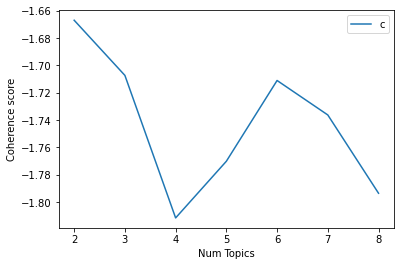

Num Topics = 2  is having Coherence Value of -1.667
Num Topics = 3  is having Coherence Value of -1.7074
Num Topics = 4  is having Coherence Value of -1.8116
Num Topics = 5  is having Coherence Value of -1.7702
Num Topics = 6  is having Coherence Value of -1.7111
Num Topics = 7  is having Coherence Value of -1.7363
Num Topics = 8  is having Coherence Value of -1.7936


In [24]:
# make plot
%matplotlib inline
import matplotlib.pyplot as plt

limit=9; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

# 4. Network Analysis

### Read the json file with authors' information.

In [25]:
import json
from pandas.io.json import json_normalize

with open("/Users/zh15n/OneDrive - University of Tennessee/PhD/Social Media/2_Authors.json") as json_data:
    data = json.load(json_data)

In [26]:
Authors = pd.Series(data['Author'])

In [27]:
Authors.head()

0                   [Dirk Hundertmark, Shuanglin Shao]
1                        [Jinggang Tan, Jingang Xiong]
2    [Michael Gekhtman, Michael Shapiro, Alek Vains...
3    [Tran Vu Khanh, Stefano Pinton, Giuseppe Zampi...
4                                                 None
dtype: object

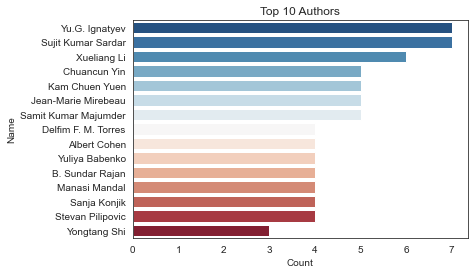

In [28]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("white")

# Top 15 authors
plt.plot
authors_flat = [
    author
    for authors in list(Authors.dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(15), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


plt.show()

In [29]:
from itertools import combinations
import networkx as nx
from nxviz import CircosPlot

# Extract author connections
authors = Authors.dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

In [30]:
print(nx.info(G))

Graph with 2639 nodes and 2761 edges


## Graphs

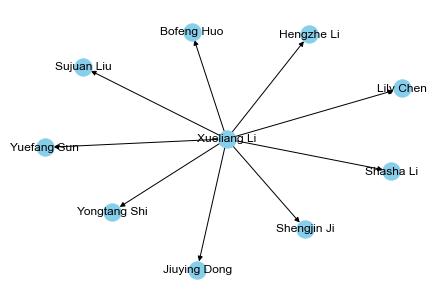

In [31]:
tree = nx.bfs_tree(G, 'Xueliang Li')
nx.draw(tree, node_color='skyblue', with_labels=True)

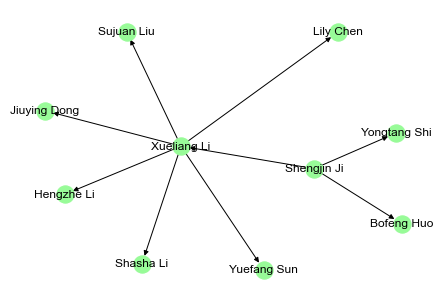

In [32]:
tree2 = nx.bfs_tree(G, 'Shengjin Ji')
nx.draw(tree2, node_color='palegreen', with_labels=True)

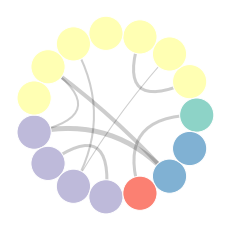

In [33]:
# Limit to TOP 15 authors
top15authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(15), columns=["Name", "Count"]
)

top15_nodes = (n for n in list(G.nodes()) if n in list(top15authors["Name"]))

G_15 = G.subgraph(top15_nodes)

for n in G_15.nodes():
    G_15.nodes[n]["publications"] = int(
        top15authors[top15authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_15,
    node_grouping="publications",
    edge_width="Count",
    node_color="publications"
)

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=6,6
c.draw
plt.show()